In [42]:
#Import the required libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, log_loss, accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score,roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack

In [43]:
#Surpress the UserWarning during Runtime  
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Suppress only UserWarning
warnings.filterwarnings('ignore', category=UserWarning)

In [44]:
#Load dataset
df = pd.read_csv('Datasets/Password_Strength_Dataset.csv') 

#Data cleaning
df_dropna = df.dropna()  

def strength_to_numeric(strength):
  if strength == 'Weak':
    return 0
  elif strength == 'Medium':
    return 1
  elif strength == 'Strong':
    return 2



In [45]:
#Password Strength Encoding
df['num_strength'] = df['Strength'].apply(strength_to_numeric)

#Shuffle dataset for randomness and robustness
data = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [46]:
#Feature Extraction
def password_length(password):
    return len(password)

def count_digits(password):
    return sum(char.isdigit() for char in password)

def count_uppercase(password):
    return sum(char.isupper() for char in password)

def count_special_characters(password):
    return sum(not char.isalnum() for char in password)

data['length'] = data['Password'].apply(password_length)
data['digits'] = data['Password'].apply(count_digits)
data['uppercase'] = data['Password'].apply(count_uppercase)
data['special_chars'] = data['Password'].apply(count_special_characters)

In [47]:
# Group the data by the 'length' column
grouped = data.groupby('length')

group_counts = grouped.size()

#print("Counts of each group:")
#print(group_counts)

# Print the highest count
highest_count = group_counts.max()
highest_length = group_counts.idxmax()
print(f"Highest count: {highest_count} for length {highest_length}")

# Print the lowest count
lowest_count = group_counts.min()
lowest_length = group_counts.idxmin()
print(f"Lowest count: {lowest_count} for length {lowest_length}")

#Verify the count for specific length
specific_length = 7 

# Print the size for the specific length
specific_length_count = group_counts.get(specific_length, 0)
print(f"Count for length {specific_length}: {specific_length_count}")

Highest count: 748 for length 8
Lowest count: 679 for length 16
Count for length 7: 710


In [48]:
# Choose a specific group to run the code on
selected_length = 15
selected_group = grouped.get_group(selected_length)

In [49]:
# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the passwords
X_password = vectorizer.fit_transform(selected_group['Password'])
X_additional = selected_group[['digits', 'uppercase', 'special_chars']].values
X = hstack([X_password, X_additional])

# Encode the labels
y = selected_group['num_strength']

In [50]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Resample data
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

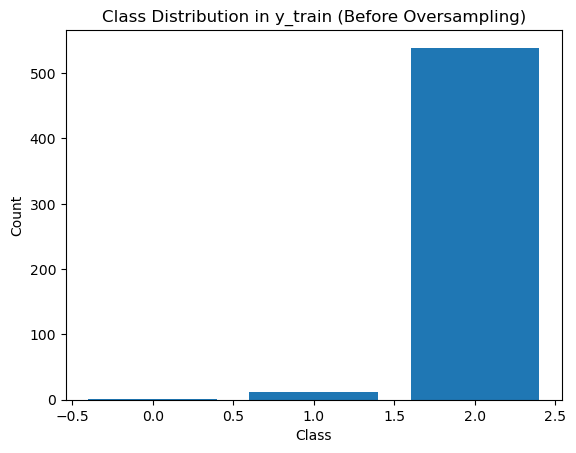

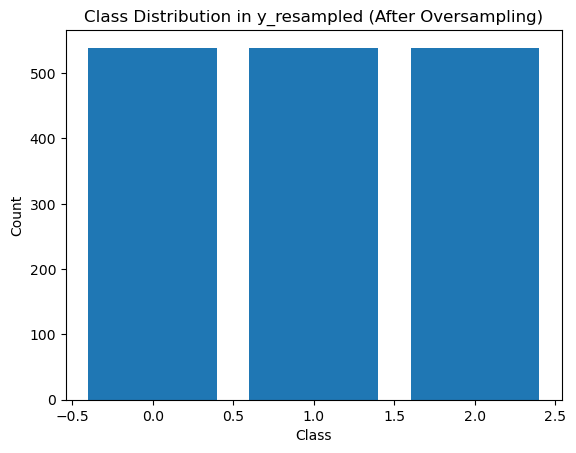

In [51]:
# Plot class distribution
def plot_class_distribution(y, title):
    class_counts = pd.Series(y).value_counts()
    plt.bar(class_counts.index, class_counts.values)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

plot_class_distribution(y_train, 'Class Distribution in y_train (Before Oversampling)')
plot_class_distribution(y_resampled, 'Class Distribution in y_resampled (After Oversampling)')


In [52]:
# Define a custom log_loss scorer
def custom_log_loss_scorer(y_true, y_pred_proba):
    return log_loss(y_true, y_pred_proba, labels=[0, 1, 2])

scorer_log_loss = make_scorer(custom_log_loss_scorer, response_method='predict_proba')


In [53]:
# Define parameter grids
param_grid1 = [
    {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'solver': ['lbfgs', 'saga'], 'max_iter': [500, 1000, 2000, 5000], 'tol': [0.0001, 0.001]},
    {'penalty': ['l1'], 'C': [0.1, 1, 10, 100], 'solver': ['liblinear'], 'max_iter': [500, 1000, 2000, 5000], 'tol': [0.0001, 0.001]},
    {'penalty': ['elasticnet'], 'C': [0.1, 1, 10, 100], 'solver': ['saga'], 'max_iter': [500, 1000, 2000, 5000], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}
]

param_grid2 = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best'],
    'max_depth': [10, 15, 20],  
    'min_samples_split': [5, 8, 10],  
    'min_samples_leaf': [2, 3, 4],  
}

param_grid3 = {
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}


In [54]:
# Define KFold
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Function to run grid search and measure training time
def run_grid_search(model, param_grid, scorer):
    start_time = time.time()
    
    # Check if the model is RandomForestClassifier and adjust parameters accordingly
    if isinstance(model, RandomForestClassifier):
        grid_search = GridSearchCV(
            estimator=RandomForestClassifier(random_state=42), 
            param_grid=param_grid, 
            scoring=scorer, 
            cv=kfold, 
            verbose=3,  # Increased verbosity for RandomForest
            n_jobs=-1, 
            return_train_score=True
        )
    else:
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grid, 
            scoring=scorer, 
            cv=kfold, 
            verbose=2,  # Default verbosity for other models
            n_jobs=-1, 
            return_train_score=True
        )
    
    grid_search.fit(X_resampled, y_resampled)
    end_time = time.time()
    
    training_time = end_time - start_time
    print(f"Training time for {model.__class__.__name__}: {training_time / 60:.2f} minutes")

    train_scores = grid_search.cv_results_['mean_train_score'] if 'mean_train_score' in grid_search.cv_results_ else []
    val_scores = grid_search.cv_results_['mean_test_score'] if 'mean_test_score' in grid_search.cv_results_ else []

    return grid_search, train_scores, val_scores, training_time


In [55]:
# Function to ompute the metrics
def compute_metrics(best_model, X_train, y_train, X_test, y_test):
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    y_train_pred_proba = best_model.predict_proba(X_train) if hasattr(best_model, 'predict_proba') else None
    y_test_pred_proba = best_model.predict_proba(X_test) if hasattr(best_model, 'predict_proba') else None

    unique_labels = np.unique(np.concatenate([y_train, y_test]))  # Get unique labels from both train and test data
    
    # Calculate the evaluation metrics for both training and testing data
    metrics_dict = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_precision': precision_score(y_train, y_train_pred, average='weighted', zero_division=0),
        'test_precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'train_recall': recall_score(y_train, y_train_pred, average='weighted', zero_division=0),
        'test_recall': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'train_f1': f1_score(y_train, y_train_pred, average='weighted'),
        'test_f1': f1_score(y_test, y_test_pred, average='weighted')
    }

    if y_train_pred_proba is not None:
        metrics_dict['train_log_loss'] = log_loss(y_train, y_train_pred_proba, labels=unique_labels)
    if y_test_pred_proba is not None:
        metrics_dict['test_log_loss'] = log_loss(y_test, y_test_pred_proba, labels=unique_labels)

    return metrics_dict


In [56]:
# Function to display metrics
def display_metrics(best_model, X_train, y_train, X_test, y_test):
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    metrics_dict = compute_metrics(best_model, X_train, y_train, X_test, y_test)
    
    # Display metrics
    for metric, value in metrics_dict.items():
        print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

    # Print the best parameters if they exist
    if hasattr(best_model, 'best_params_'):
        print(f"\nBest Parameters: {best_model.best_params_}")

    print("\nClassification Report on Training Data:")
    print(classification_report(y_train, y_train_pred, zero_division=0))

    print("\nClassification Report on Test Data:")
    print(classification_report(y_test, y_test_pred, zero_division=0))

    print("\nConfusion Matrix on Training Data:")
    print(confusion_matrix(y_train, y_train_pred))

    print("\nConfusion Matrix on Test Data:")
    print(confusion_matrix(y_test, y_test_pred))

    return metrics_dict


In [57]:
def autolabel(rects, ax):
    """Attach a text label inside each bar in *rects*, slightly below the top."""
    for rect in rects:
        height = rect.get_height()
        
        y_pos = height * 0.95  
        ax.annotate(f'{height:.4f}',  
                    xy=(rect.get_x() + rect.get_width() / 2, y_pos),
                    xytext=(0, 0), 
                    textcoords="offset points",
                    ha='center', va='center',
                    fontsize=10,  
                    color='black')  

# Function to Plot metrics
def plot_metrics(metrics):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

    # Prepare data for plotting
    train_metrics = {
        'Logistic Regression': [metrics_dict['Logistic Regression']['train_accuracy'], 
                                metrics_dict['Logistic Regression']['train_precision'], 
                                metrics_dict['Logistic Regression']['train_recall'], 
                                metrics_dict['Logistic Regression']['train_f1']],
        'Decision Tree': [metrics_dict['Decision Tree']['train_accuracy'], 
                          metrics_dict['Decision Tree']['train_precision'], 
                          metrics_dict['Decision Tree']['train_recall'], 
                          metrics_dict['Decision Tree']['train_f1']],
        'Random Forest': [metrics_dict['Random Forest']['train_accuracy'], 
                          metrics_dict['Random Forest']['train_precision'], 
                          metrics_dict['Random Forest']['train_recall'], 
                          metrics_dict['Random Forest']['train_f1']]
    }
    
    test_metrics = {
        'Logistic Regression': [metrics_dict['Logistic Regression']['test_accuracy'], 
                                metrics_dict['Logistic Regression']['test_precision'], 
                                metrics_dict['Logistic Regression']['test_recall'], 
                                metrics_dict['Logistic Regression']['test_f1']],
        'Decision Tree': [metrics_dict['Decision Tree']['test_accuracy'], 
                          metrics_dict['Decision Tree']['test_precision'], 
                          metrics_dict['Decision Tree']['test_recall'], 
                          metrics_dict['Decision Tree']['test_f1']],
        'Random Forest': [metrics_dict['Random Forest']['test_accuracy'], 
                          metrics_dict['Random Forest']['test_precision'], 
                          metrics_dict['Random Forest']['test_recall'], 
                          metrics_dict['Random Forest']['test_f1']]
    }

    colors = {
        'Logistic Regression': 'lightblue',
        'Decision Tree': 'lightgreen',
        'Random Forest': 'salmon'
    }

    x = np.arange(len(metrics))  # the label locations
    width = 0.20  # Width of the bars

    fig, ax = plt.subplots(2, 1, figsize=(15, 15))  # Figure size

    num_models = len(train_metrics)
    total_width = width * num_models  # Total width of a group of bars
    spacing = 0.2  # Adjust this value to control the space between groups

    # Adjust the spacing between groups of bars
    bar_positions = np.arange(len(metrics)) * (total_width + spacing)  # Recalculate positions with reduced spacing

    # Plotting bars for each model with different colors
    for i, (label, values) in enumerate(train_metrics.items()):
        bars = ax[0].bar(bar_positions + i * width - total_width / 2, values, width, label=label, color=colors[label])
        autolabel(bars, ax[0])

    ax[0].set_xlabel('Metrics')
    ax[0].set_ylabel('Scores')
    ax[0].set_title('Comparison of Training Metrics Across Models')
    ax[0].set_xticks(bar_positions)
    ax[0].set_xticklabels(metrics)
    ax[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[0].set_ylim(0, 1)
    ax[0].tick_params(axis='x', rotation=45)  

    # Plotting bars for each model with different colors
    for i, (label, values) in enumerate(test_metrics.items()):
        bars = ax[1].bar(bar_positions + i * width - total_width / 2, values, width, label=label, color=colors[label])
        autolabel(bars, ax[1])

    ax[1].set_xlabel('Metrics')
    ax[1].set_ylabel('Scores')
    ax[1].set_title('Comparison of Testing Metrics Across Models')
    ax[1].set_xticks(bar_positions)
    ax[1].set_xticklabels(metrics)
    ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    ax[1].set_ylim(0, 1)
    ax[1].tick_params(axis='x', rotation=45)  

    fig.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust layout to make more space for labels
    plt.show()


In [58]:
# Function to plot the learning curve 
def plot_learning_curve(model, X, y, model_name):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Get learning curve data
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=kfold, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), 
        scoring='accuracy'
    )
    
    # Calculate mean and standard deviation for training and validation scores
    train_mean = np.mean(train_scores, axis=1)
    validation_mean = np.mean(validation_scores, axis=1)
    
    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, validation_mean, 'o-', color='green', label='Validation score')
    
    plt.fill_between(train_sizes, train_mean - np.std(train_scores, axis=1), 
                     train_mean + np.std(train_scores, axis=1), alpha=0.1, color='blue')
    plt.fill_between(train_sizes, validation_mean - np.std(validation_scores, axis=1), 
                     validation_mean + np.std(validation_scores, axis=1), alpha=0.1, color='green')
    
    plt.title(f'Learning Curve ({model_name})')
    plt.xlabel('Training examples')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Determine the point of convergence
    convergence_point = np.argmax(validation_mean)
    convergence_score = validation_mean[convergence_point]
    
    print(f"\n{model_name} converges at {train_sizes[convergence_point]} training examples with a validation score of {convergence_score:.3f}")
    
    return train_sizes[convergence_point], convergence_score

In [59]:
# Function to plot computational times of different models in minutes
def plot_computational_time(training_times):
    models = list(training_times.keys())
    times_seconds = list(training_times.values())
    times_minutes = [t / 60 for t in times_seconds]  # Convert seconds to minutes

    plt.figure(figsize=(10, 6))

    # Plot the computational time as a line graph
    plt.plot(models, times_minutes, marker='o', color='salmon', linestyle='-', linewidth=2, markersize=8)

    # Add labels and title
    plt.title('Computational Time of Different Models (in minutes)')
    plt.xlabel('Model')
    plt.ylabel('Training Time (minutes)')

    # Annotate each point with its value
    for i, value in enumerate(times_minutes):
        plt.text(models[i], value, f'{value:.2f}', fontsize=10, ha='center', va='bottom')

    # Show the plot
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()


In [60]:
#Initialize the ML models
models = {
    'Logistic Regression': LogisticRegression( random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}


In [61]:
# Store metrics and convergence points
metrics_dict = {}
convergence_points = {}

In [62]:
# Run grid search for Logistic Regression
print("Running grid search for Logistic Regression...")
logreg_model = LogisticRegression(random_state=42)
logreg_search, logreg_train_scores, logreg_val_scores,logistic_training_time = run_grid_search(logreg_model, param_grid1, scorer_log_loss)


Running grid search for Logistic Regression...
Fitting 3 folds for each of 208 candidates, totalling 624 fits
Training time for LogisticRegression: 1.23 minutes


In [63]:
#Print the evaluation metrics for Logistic Regression
print("Logistic Regression Metrics:")
logreg_best_model = logreg_search.best_estimator_

if hasattr(logreg_search, 'best_params_'):
    print(f"Best Parameters for Logistic Regression: {logreg_search.best_params_}")
logreg_metrics = display_metrics(logreg_best_model, X_train, y_train, X_test, y_test)


Logistic Regression Metrics:
Best Parameters for Logistic Regression: {'C': 0.001, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Train Accuracy: 0.6739
Test Accuracy: 0.6739
Train Precision: 0.9670
Test Precision: 0.9753
Train Recall: 0.6739
Test Recall: 0.6739
Train F1: 0.7846
Test F1: 0.7925
Train Log Loss: 0.9215
Test Log Loss: 0.9375

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.07      1.00      0.12         1
           1       0.05      0.67      0.09        12
           2       0.99      0.67      0.80       539

    accuracy                           0.67       552
   macro avg       0.37      0.78      0.34       552
weighted avg       0.97      0.67      0.78       552


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.02      0.50      0.05         2
           2      

Plotting learning curve for Logistic Regression...


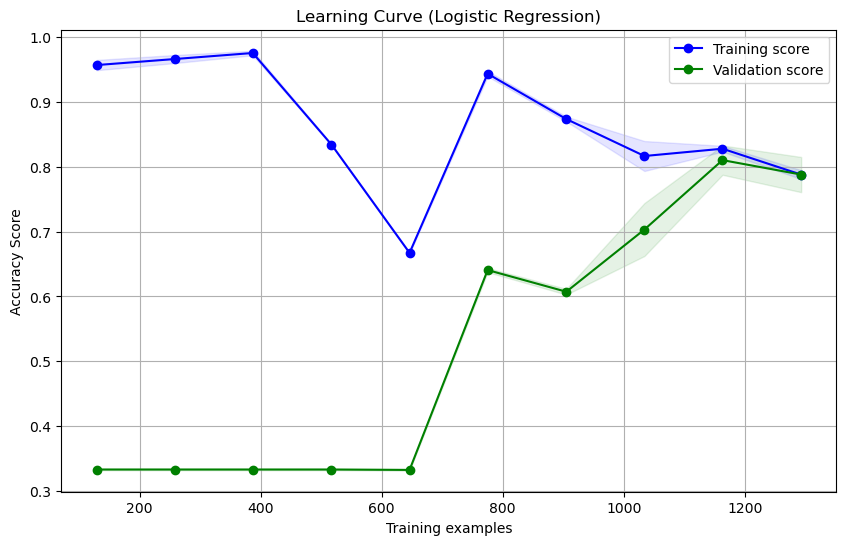


Logistic Regression converges at 1163 training examples with a validation score of 0.810


In [64]:
#Plot the learning curve for Logistic Regression
print("Plotting learning curve for Logistic Regression...")
logreg_convergence_point, logreg_convergence_score = plot_learning_curve(logreg_best_model, X_resampled, y_resampled, 'Logistic Regression')
convergence_points['Logistic Regression'] = (logreg_convergence_point, logreg_convergence_score)


In [65]:
# Run grid search for Decision Tree
print("Running grid search for Decision Tree...")
tree_model = DecisionTreeClassifier(random_state=42)
tree_search, tree_train_scores, tree_val_scores,decision_tree_training_time = run_grid_search(tree_model, param_grid2, scorer_log_loss)


Running grid search for Decision Tree...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Training time for DecisionTreeClassifier: 0.02 minutes


In [66]:
#Print the evaluation metrics for Decision Tree
print("Decision Tree Metrics:")
tree_best_model = tree_search.best_estimator_

if hasattr(tree_search, 'best_params_'):
    print(f"Best Parameters for Decision Tree: {tree_search.best_params_}")
tree_metrics = display_metrics(tree_best_model, X_train, y_train, X_test, y_test)


Decision Tree Metrics:
Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'splitter': 'best'}
Train Accuracy: 1.0000
Test Accuracy: 0.9928
Train Precision: 1.0000
Test Precision: 0.9928
Train Recall: 1.0000
Test Recall: 0.9928
Train F1: 1.0000
Test F1: 0.9916
Train Log Loss: 0.0000
Test Log Loss: 0.2612

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00       539

    accuracy                           1.00       552
   macro avg       1.00      1.00      1.00       552
weighted avg       1.00      1.00      1.00       552


Classification Report on Test Data:
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       0.99      1.00      1.00       136

  

Plotting learning curve for Decision Tree...


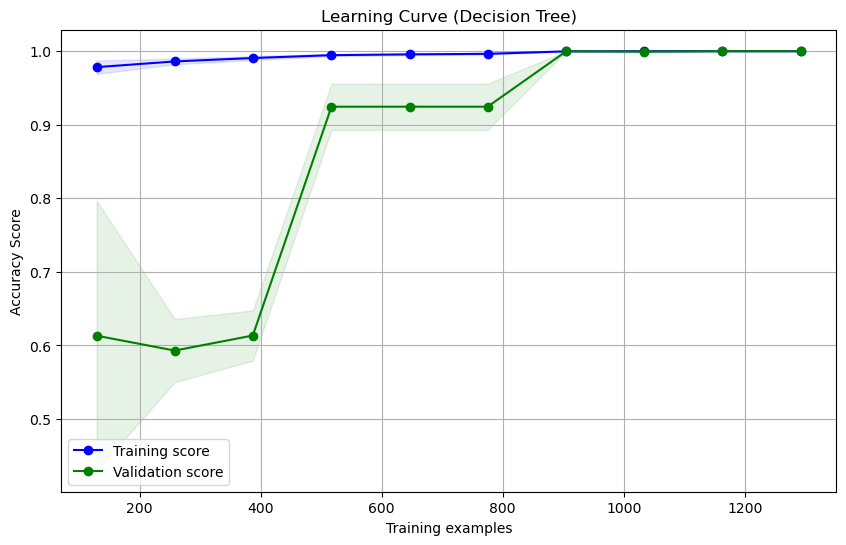


Decision Tree converges at 905 training examples with a validation score of 1.000


In [67]:
#Plot the learning curve for Decision Tree
print("Plotting learning curve for Decision Tree...")
tree_convergence_point, tree_convergence_score = plot_learning_curve(tree_best_model, X_resampled, y_resampled, 'Decision Tree')
convergence_points['Decision Tree'] = (tree_convergence_point, tree_convergence_score)


In [68]:
# Run grid search for Random Forest
print("Running grid search for Random Forest...")
forest_model = RandomForestClassifier(random_state=42, n_jobs=-1)
forest_search, forest_train_scores, forest_val_scores,random_forest_training_time = run_grid_search(forest_model, param_grid3, scorer_log_loss)


Running grid search for Random Forest...
Fitting 3 folds for each of 1080 candidates, totalling 3240 fits
Training time for RandomForestClassifier: 9.74 minutes


In [69]:
#Print the evaluation metrics for Random Forest
print("Random Forest Metrics:")
forest_best_model = forest_search.best_estimator_

if hasattr(forest_search, 'best_params_'):
    print(f"Best Parameters for Random Forest: {forest_search.best_params_}")
forest_metrics = display_metrics(forest_best_model, X_train, y_train, X_test, y_test)


Random Forest Metrics:
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Train Accuracy: 0.9909
Test Accuracy: 0.9855
Train Precision: 0.9904
Test Precision: 0.9712
Train Recall: 0.9909
Test Recall: 0.9855
Train F1: 0.9903
Test F1: 0.9783
Train Log Loss: 1.0781
Test Log Loss: 1.0799

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.89      0.67      0.76        12
           2       0.99      1.00      1.00       539

    accuracy                           0.99       552
   macro avg       0.96      0.89      0.92       552
weighted avg       0.99      0.99      0.99       552


Classification Report on Test Data:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.99      1.00

Plotting learning curve for Random Forest...


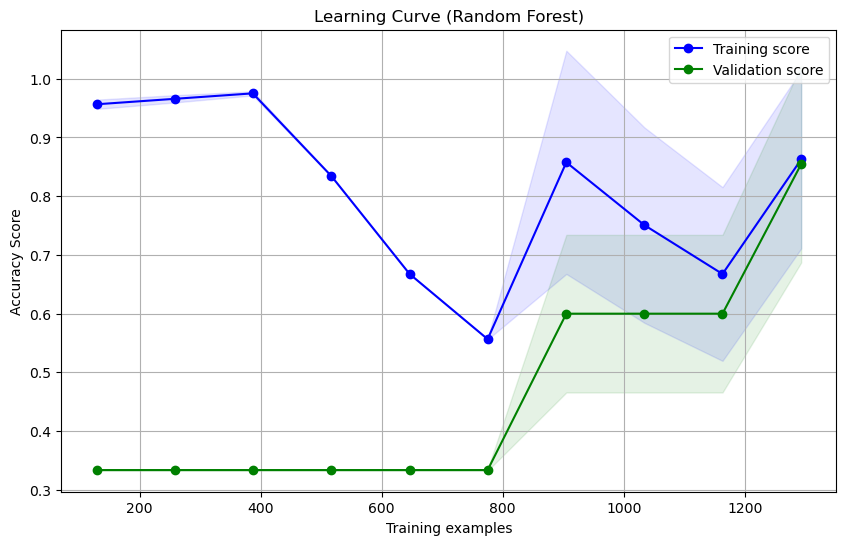


Random Forest converges at 1293 training examples with a validation score of 0.855


In [70]:
#Plot the learning curve for Random Forest
print("Plotting learning curve for Random Forest...")
forest_convergence_point,forest_convergence_score = plot_learning_curve(forest_best_model, X_resampled, y_resampled, 'Random Forest')
convergence_points['Random Forest'] = (forest_convergence_point, forest_convergence_score)


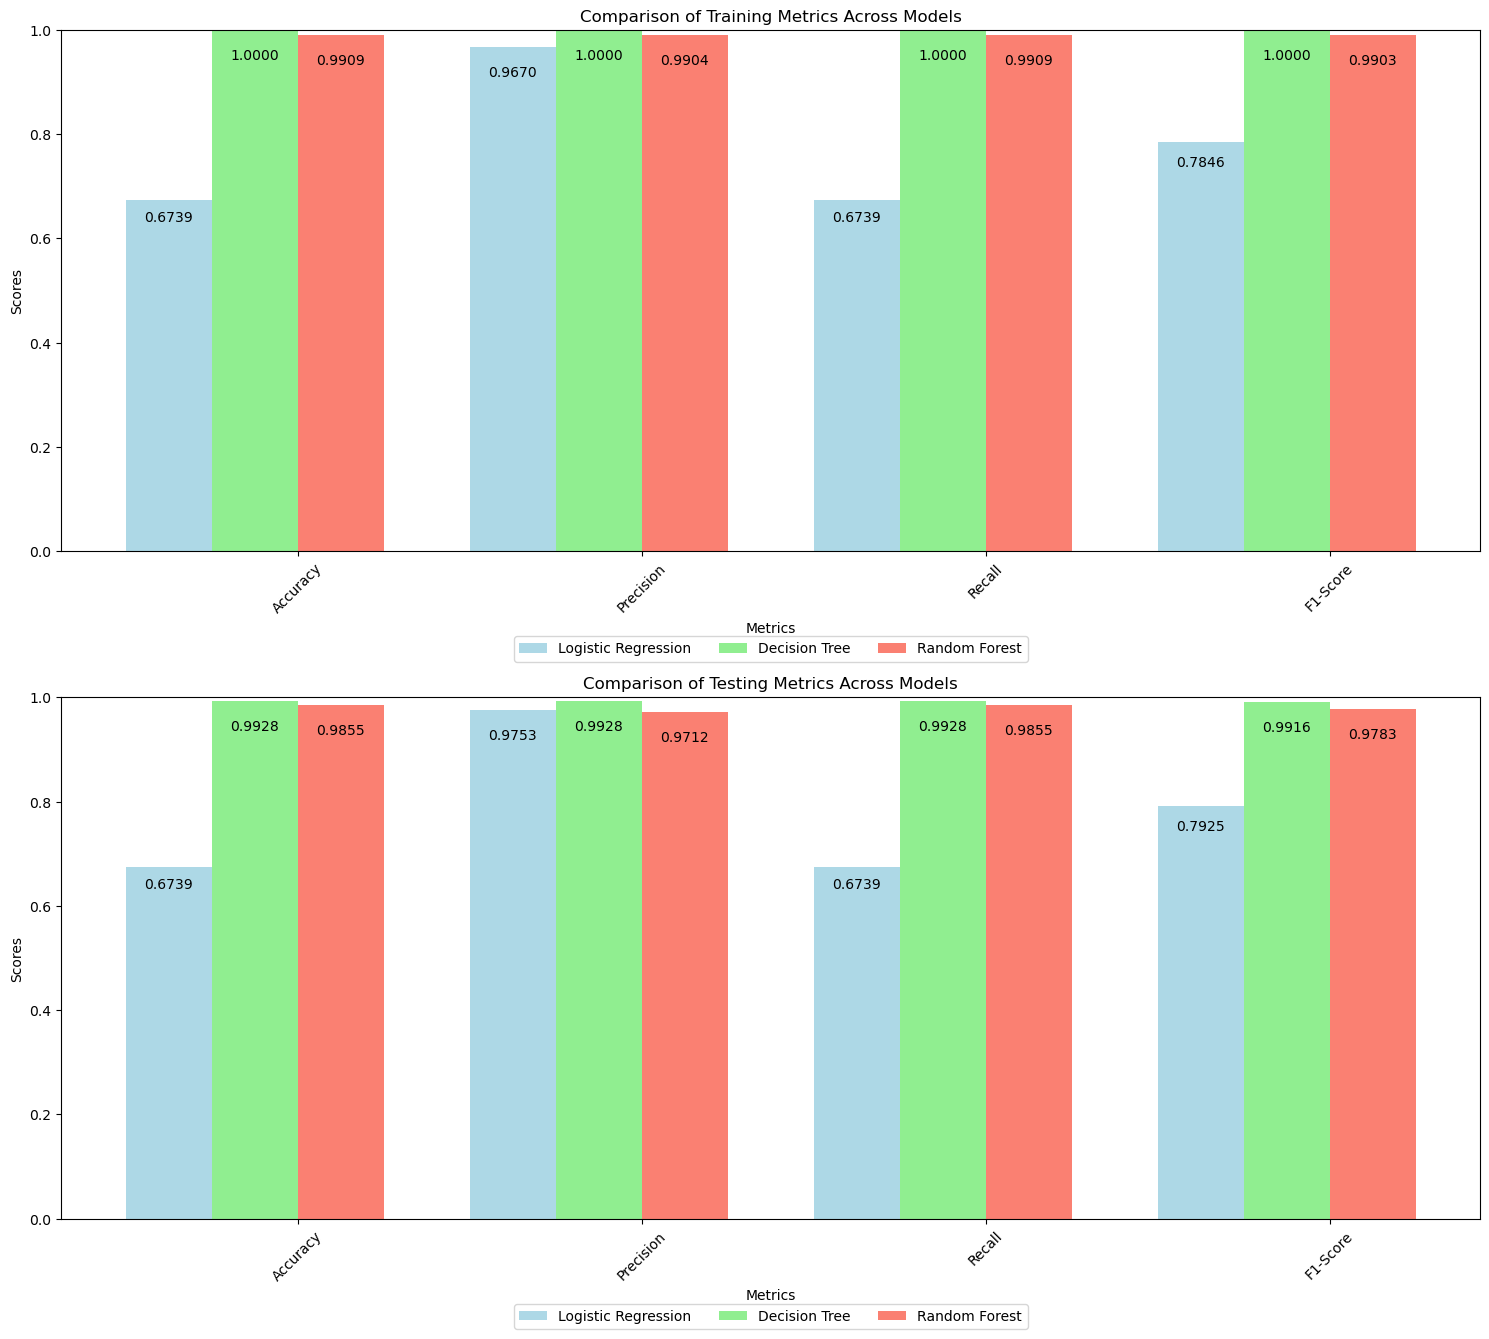

In [71]:
# Store metrics
metrics_dict = {
    'Logistic Regression': logreg_metrics,
    'Decision Tree': tree_metrics,
    'Random Forest': forest_metrics
}

# Plot metrics
plot_metrics(metrics_dict)

In [72]:
# Print convergence points
for name, (point, score) in convergence_points.items():
    print(f"{name}: {point} training examples with a score of {score:.3f}")

Logistic Regression: 1163 training examples with a score of 0.810
Decision Tree: 905 training examples with a score of 1.000
Random Forest: 1293 training examples with a score of 0.855


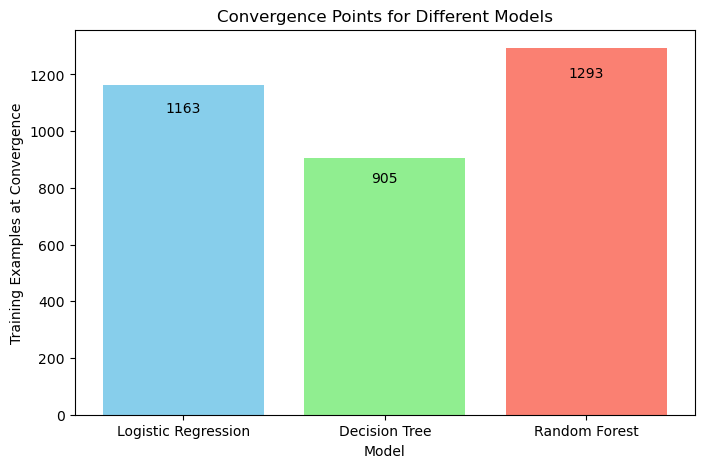

In [73]:
# Plot convergence points
plt.figure(figsize=(8, 5))

# Extract values for plotting
convergence_values = [point for point, _ in convergence_points.values()]  # Extract only the training examples
model_names = list(convergence_points.keys())

# Plot the bar graph
bars = plt.bar(model_names, convergence_values, color=['skyblue', 'lightgreen', 'salmon'])

# Add labels inside the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - (yval * 0.05), int(yval), ha='center', va='top', color='black')

# Set title and labels
plt.title('Convergence Points for Different Models')
plt.xlabel('Model')
plt.ylabel('Training Examples at Convergence')

# Show the plot
plt.show()


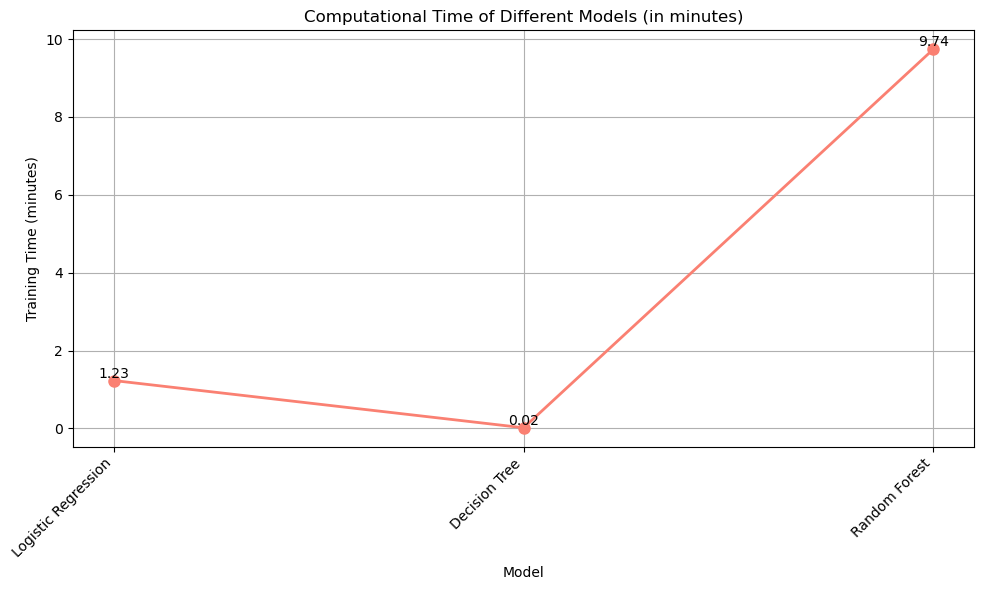

In [74]:
# Dictionary to store the training times of each model
training_times = {
    'Logistic Regression': logistic_training_time,
    'Decision Tree': decision_tree_training_time,
    'Random Forest': random_forest_training_time
}

#Plot computational time
plot_computational_time(training_times)


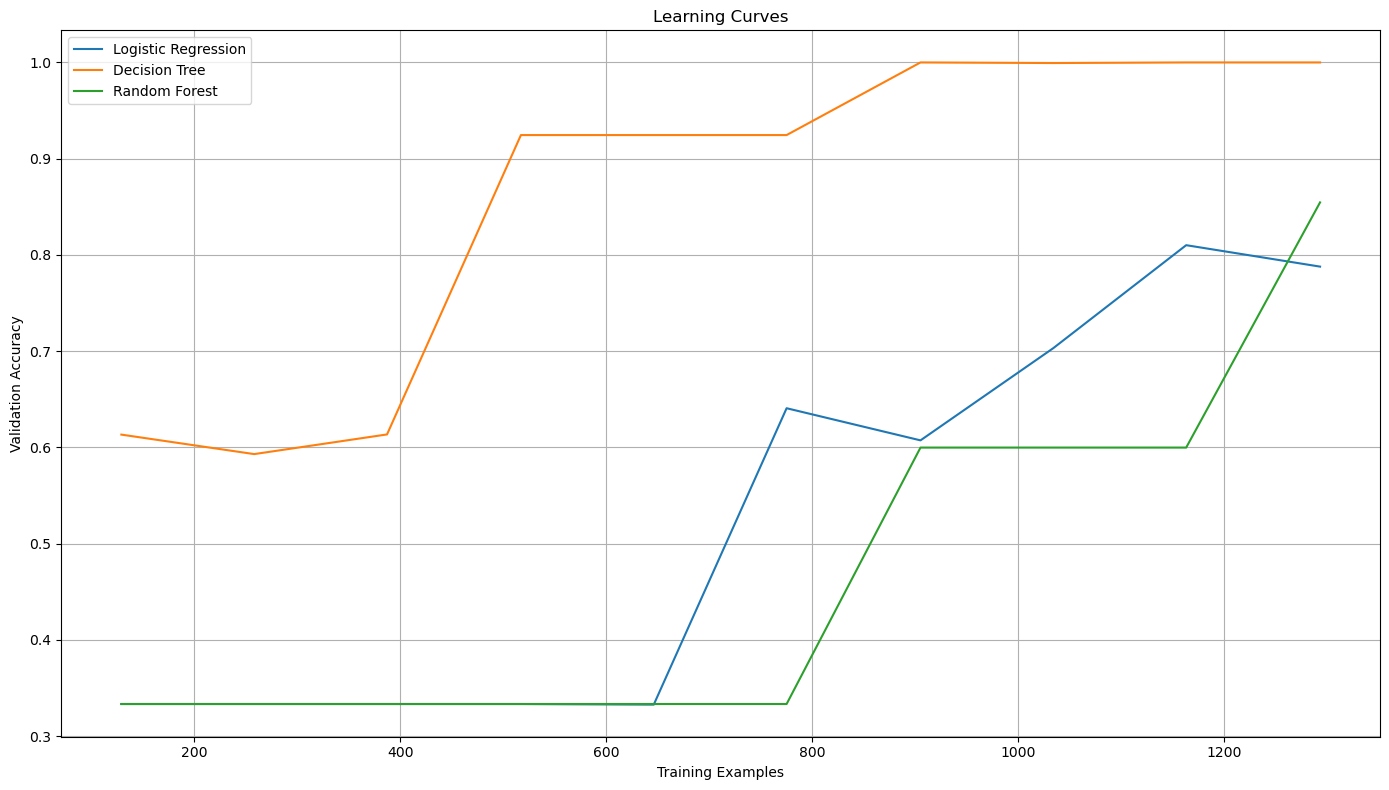

In [75]:
#Function to compute the learning curve for all models
def compute_learning_curve(model, X, y):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, cv=kfold, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 10), 
        scoring='accuracy'
    )
    return train_sizes, np.mean(train_scores, axis=1), np.mean(validation_scores, axis=1)

def plot_curves(models, X_train, y_train):
    plt.figure(figsize=(14, 8))

    # Plot learning curves
    plt.subplot(1, 1, 1)
    for name, model in models.items():
        train_sizes, train_scores, val_scores = compute_learning_curve(model, X_train, y_train)
        plt.plot(train_sizes, val_scores, label=name)
    plt.title('Learning Curves')
    plt.xlabel('Training Examples')
    plt.ylabel('Validation Accuracy')
    plt.legend(loc='best')
    plt.grid()

    plt.tight_layout()
    plt.show()

# Define models
models = {
    'Logistic Regression': logreg_search.best_estimator_,
    'Decision Tree': tree_best_model,
    'Random Forest': forest_search.best_estimator_
}

# Plot learning curves
plot_curves(models, X_resampled, y_resampled)


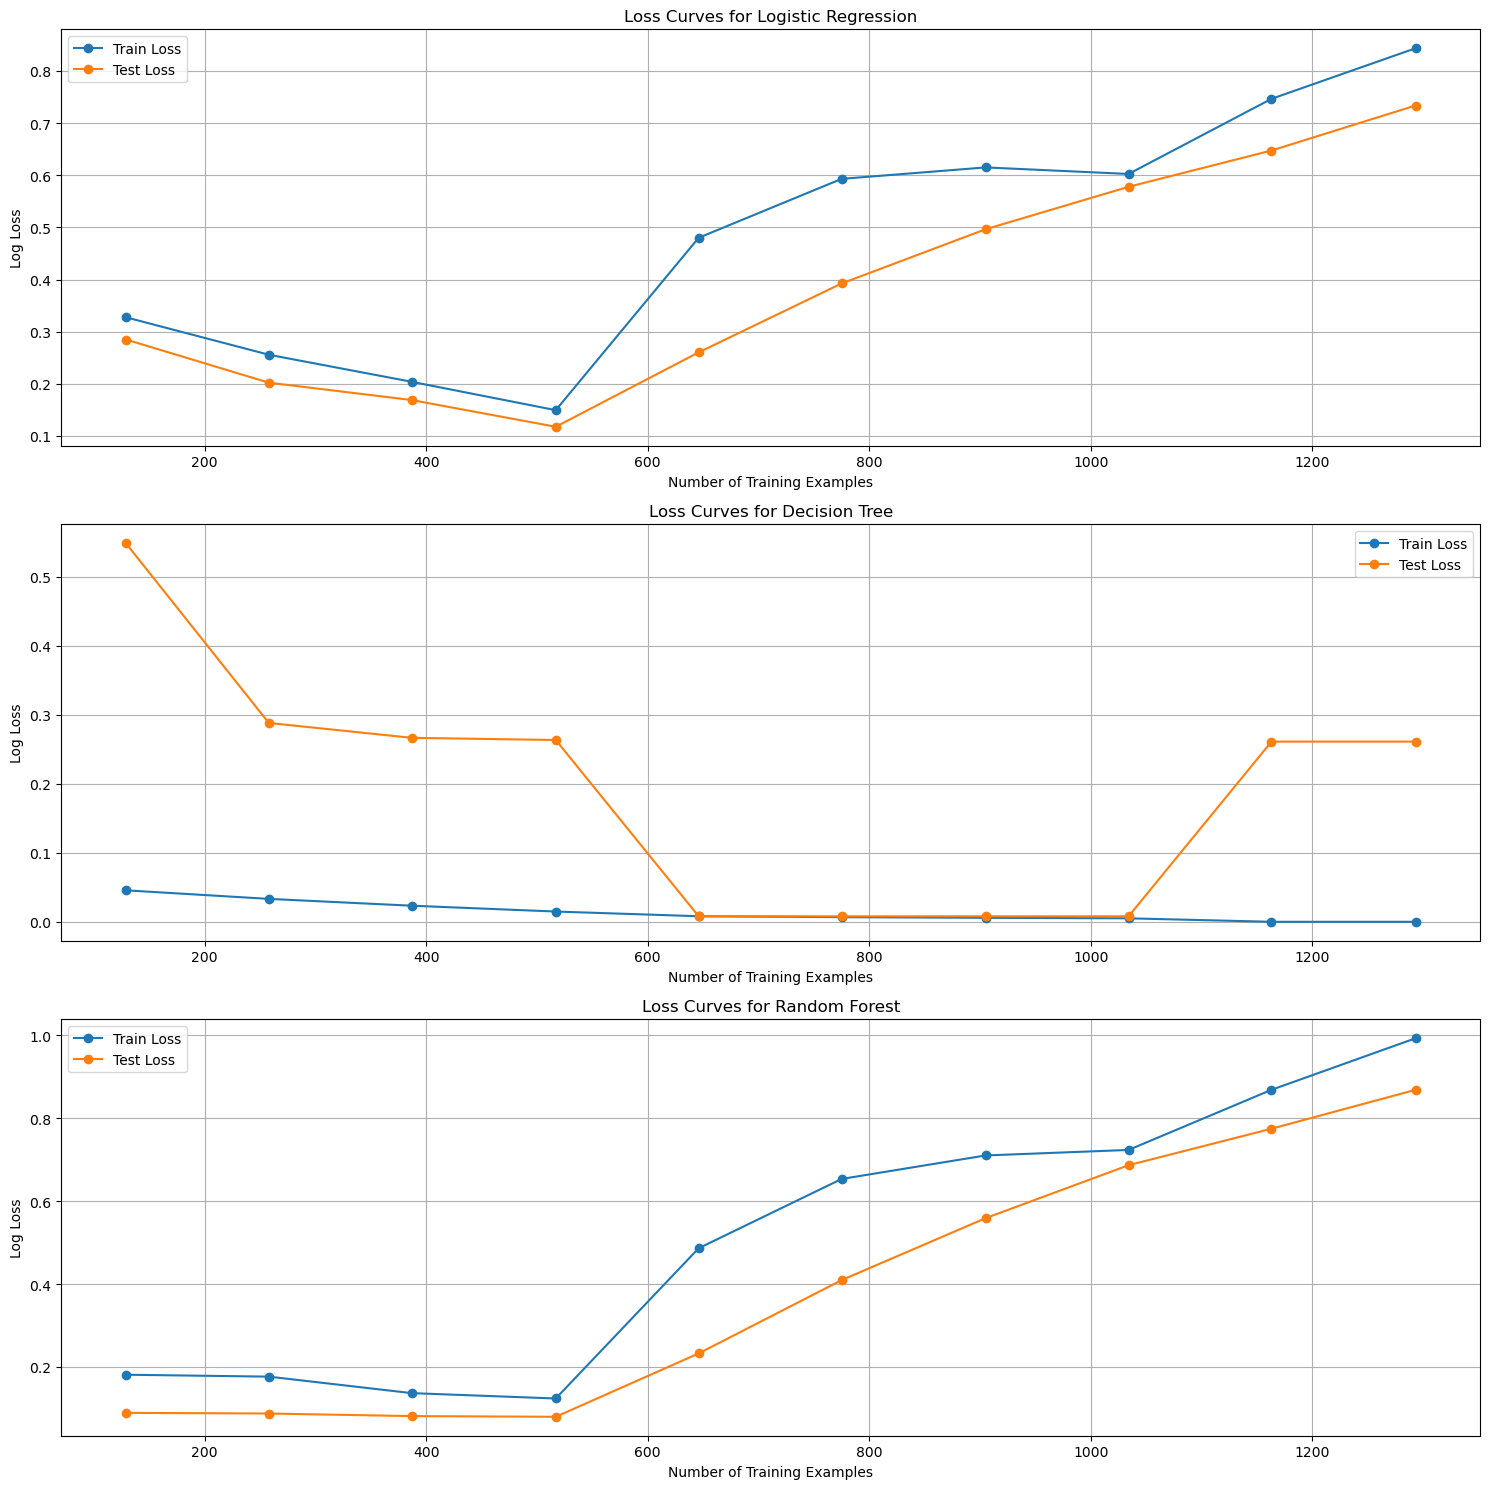

In [76]:
#Function to compute the loss curve for each model

def compute_losses(model, X_train, y_train, X_test, y_test):
    train_sizes, _, _ = compute_learning_curve(model, X_train, y_train)
    train_losses = []
    test_losses = []
    
    all_classes = np.unique(y_train)  # Get all classes in the training set
    
    for size in train_sizes:
        model.fit(X_train[:int(size)], y_train[:int(size)])
        y_train_pred_proba = model.predict_proba(X_train[:int(size)])
        y_test_pred_proba = model.predict_proba(X_test)
        
        # Calculate train and test losses
        train_losses.append(log_loss(y_train[:int(size)], y_train_pred_proba, labels=all_classes))
        test_losses.append(log_loss(y_test, y_test_pred_proba, labels=all_classes))
    
    return train_sizes, train_losses, test_losses

def plot_curves(models, X_train, y_train, X_test, y_test):
    num_models = len(models)
    plt.figure(figsize=(15, 5 * num_models))
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(num_models, 1, i)
        train_sizes, train_losses, test_losses = compute_losses(model, X_train, y_train, X_test, y_test)
        
        plt.plot(train_sizes, train_losses, label='Train Loss', marker='o')
        plt.plot(train_sizes, test_losses, label='Test Loss', marker='o')
        
        plt.title(f'Loss Curves for {name}')
        plt.xlabel('Number of Training Examples')
        plt.ylabel('Log Loss')
        plt.legend(loc='best')
        plt.grid()
    
    plt.tight_layout()
    plt.show()

# Define models
models = {
    'Logistic Regression': logreg_search.best_estimator_,
    'Decision Tree': tree_search.best_estimator_,
    'Random Forest': forest_search.best_estimator_
}

# Plot curves
plot_curves(models, X_resampled, y_resampled, X_test, y_test)


Classes present in y_test: [1 2]

Evaluating Logistic Regression
Shape of y_score: (138, 3)

Evaluating Decision Tree
Shape of y_score: (138, 3)

Evaluating Random Forest
Shape of y_score: (138, 3)


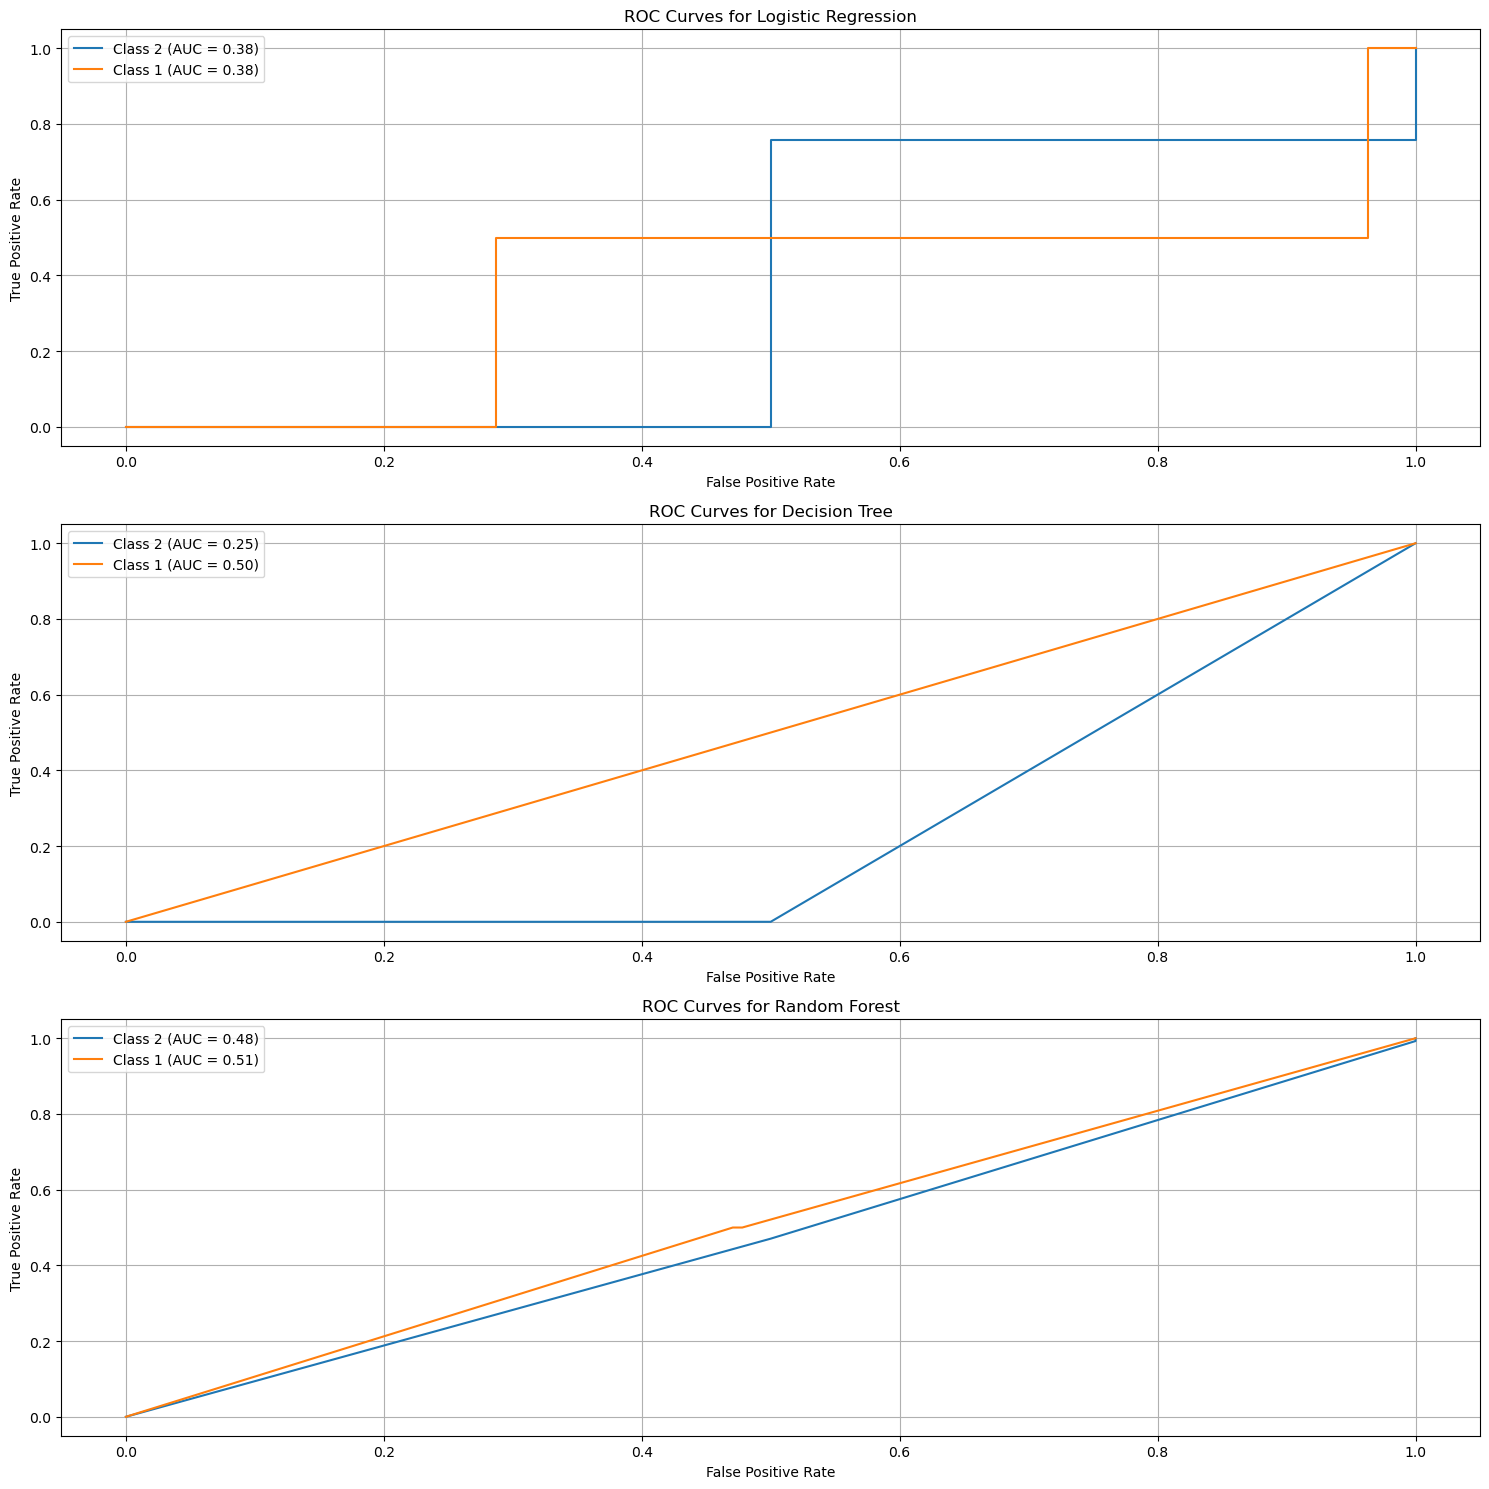

In [77]:
#Function to plot the ROC and AUC values
def plot_roc_auc(models, X_test, y_test):
    plt.figure(figsize=(15, 5 * len(models)))
    
    # Identify unique classes
    classes_present = np.unique(y_test)
    num_classes = len(classes_present)
    
    print(f"Classes present in y_test: {classes_present}")
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(len(models), 1, i)
        y_score = model.predict_proba(X_test)
        
        fpr = {}
        tpr = {}
        roc_auc = {}
        
        print(f"\nEvaluating {name}")
        print(f"Shape of y_score: {y_score.shape}")
        #print(f"First few rows of y_score:\n{y_score[:5]}")
        
        if num_classes == 2:
            # Binary classification case
            # Get probabilities for class 1
            y_score_class_1 = y_score[:, 1]
            y_test_class_1 = (y_test == classes_present[1]).astype(int)
            
            fpr[1], tpr[1], _ = roc_curve(y_test_class_1, y_score_class_1)
            roc_auc[1] = auc(fpr[1], tpr[1])
            
            # Get probabilities for class 0
            y_score_class_0 = y_score[:, 0]
            y_test_class_0 = (y_test == classes_present[0]).astype(int)
            
            fpr[0], tpr[0], _ = roc_curve(y_test_class_0, y_score_class_0)
            roc_auc[0] = auc(fpr[0], tpr[0])
            
            plt.plot(fpr[1], tpr[1], label=f'Class {classes_present[1]} (AUC = {roc_auc[1]:.2f})')
            plt.plot(fpr[0], tpr[0], label=f'Class {classes_present[0]} (AUC = {roc_auc[0]:.2f})')
            
        else:
            # Multi-class case
            for j, class_label in enumerate(classes_present):
                if j < y_score.shape[1]:
                    print(f"Processing class {class_label}")
                    
                    y_test_binarized_single = (y_test == class_label).astype(int)
                    y_score_single = y_score[:, j]
                    
                    if np.any(y_test_binarized_single) and np.any(y_score_single):
                        fpr[class_label], tpr[class_label], _ = roc_curve(y_test_binarized_single, y_score_single)
                        roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])
                        plt.plot(fpr[class_label], tpr[class_label], label=f'Class {class_label} (AUC = {roc_auc[class_label]:.2f})')
                    else:
                        print(f"Warning: No positive samples for class {class_label} in y_test_binarized or y_score")
                else:
                    print(f"Warning: Class {class_label} is missing in y_score")
        
        plt.title(f'ROC Curves for {name}')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='best')
        plt.grid()
    
    plt.tight_layout()
    plt.show()

# Example usage
models = {
    'Logistic Regression': logreg_search.best_estimator_,
    'Decision Tree': tree_search.best_estimator_,
    'Random Forest': forest_search.best_estimator_
}

# Call the function to plot ROC curves and AUCs for each model
plot_roc_auc(models, X_test, y_test)
